### Bibliotecas:

In [13]:
import matplotlib.pyplot as plt
from math import atan2
from sklearn.decomposition import PCA

### Clases:

In [14]:
class Point:
    def __init__(self, coordx, coordy):
        self.x = coordx
        self.y = coordy

class Group:
    def __init__(self):
        self.points_group = []

    def add_point(self, point):
        self.points_group.append(point)

### Plotes:

In [15]:
def plt_points_train(group1, group2):
    group1_train_x = [point.x for point in group1.train_set]
    group1_train_y = [point.y for point in group1.train_set]
    group2_train_x = [point.x for point in group2.train_set]
    group2_train_y = [point.y for point in group2.train_set]
    plt.scatter(group1_train_x, group1_train_y, color='b', label='Train Set (Group 1)')
    plt.scatter(group2_train_x, group2_train_y, color='r', label='Train Set (Group 2)')
    plt.xlim([min(group1_train_x + group2_train_x) - 1, max(group1_train_x + group2_train_x) + 1])
    plt.ylim([min(group1_train_y + group2_train_y) - 1, max(group1_train_y + group2_train_y) + 1])
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

def plt_points_test(group1_test, group2_test):
    group1_test_x = [point.x for point in group1_test]
    group1_test_y = [point.y for point in group1_test]
    group2_test_x = [point.x for point in group2_test]
    group2_test_y = [point.y for point in group2_test]
    plt.scatter(group1_test_x, group1_test_y, color='green', label='Test Set (Group 1)')
    plt.scatter(group2_test_x, group2_test_y, color='gray', label='Test Set (Group 2)')
    plt.xlim([min(group1_test_x + group2_test_x) - 1, max(group1_test_x + group2_test_x) + 1])
    plt.ylim([min(group1_test_y + group2_test_y) - 1, max(group1_test_y + group2_test_y) + 1])
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
    
def plt_convex_hull(group1_x, group1_y, group2_x, group2_y):
    plt.plot(group1_x, group1_y, color='black', label='Convex Hull for Group 1')
    plt.plot(group2_x, group2_y, color='black', label='Convex Hull for Group 2')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

def plt_close_points(close_points):
    plt.plot([close_points[0][0], close_points[1][0]], [close_points[0][1], close_points[1][1]], color='green', label='Closest Points')
    plt.scatter([close_points[0][0], close_points[1][0]], [close_points[0][1], close_points[1][1]], color='purple', label='Closest Points')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
    
def plt_perpendicular_reta(perpendicular_point1, perpendicular_point2):
    plt.plot([perpendicular_point1[0], perpendicular_point2[0]], [perpendicular_point1[1], perpendicular_point2[1]], color='orange', label='Perpendicular Line')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

### Lendo dataset

In [16]:
def read_dataset(dataset_name):
    data_points = []
    with open(dataset_name, "r") as file:
        lines = file.readlines()
    data_start = lines.index("@data\n") + 1
    class_labels = []
    
    # Get Classes lines
    for line in lines:
        if line.startswith("@attribute Class"):
            class_attribute_line = line
            break
        
    # Get the first two Classes
    start_index = class_attribute_line.find('{') + 1
    end_index = class_attribute_line.find('}')
    class_values = class_attribute_line[start_index:end_index]
    classes = class_values.split(',')
    class_values_list = classes[:2]
    print(class_values_list)
    
    # Add space character to the first Class
    #class_values_list[0] = " " + class_values_list[0]
    
    for line in lines[data_start:]:
        data = line.strip().split(',')
        class_label = data[-1]
        if class_label in class_values_list:
            data_points.append([float(val) for val in data[:-1]])
            class_name = data[-1]
            class_labels.append(class_name)
            
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(data_points)

    plt.figure(figsize=(8, 6))

    unique_classes = set(class_labels)

    for class_name in unique_classes:
        indices = [i for i, label in enumerate(class_labels) if label == class_name]
        x = pca_result[indices, 0]
        y = pca_result[indices, 1]
        plt.scatter(x, y, label=class_name)

    plt.title("PCA Results")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
    plt.show()
    
    return class_labels, class_values_list, pca_result

def split_dataset(class_labels, class_values_list, pca_result):

    group1 = Group()
    group2 = Group()

    for i in range(len(pca_result)):
        point = Point(pca_result[i, 0], pca_result[i, 1])
        if class_labels[i] == class_values_list[0]:
            group1.add_point(point)
        else:
            group2.add_point(point)

    all_groups = [group1, group2]

    train_ratio = 0.7

    for group in all_groups:
        train_size = int(train_ratio * len(group.points_group))
        group.train_set = group.points_group[:train_size]
        group.test_set = group.points_group[train_size:]

    return group1, group2

### Envoltorio convexo com Graham Scan:

In [17]:
def orientation(p, q, r):
    """
    Função para verificar a orientação dos pontos (p, q, r).
    Retorna os seguintes valores:
    -1 se estão no sentido horário.
    0 se são colineares.
    1 se estão no sentido anti-horário.
    """
    val = (q.y - p.y) * (r.x - q.x) - (q.x - p.x) * (r.y - q.y)
    if val == 0:
        return 0
    return 1 if val > 0 else -1

def graham_scan(points):
    n = len(points)
    if n < 3:
        return []

    # Encontre o ponto com a menor coordenada y (e à esquerda, se houver um empate)
    min_point = min(points, key=lambda point: (point.y, point.x))

    # Classifique os pontos com base em suas polaridades em relação ao ponto mínimo
    sorted_points = sorted(points, key=lambda point: (atan2(point.y - min_point.y, point.x - min_point.x), point.x, point.y))

    # Inicialize a pilha e adicione os dois primeiros pontos
    stack = [sorted_points[0], sorted_points[1]]

    # Itere pelos pontos restantes
    for i in range(2, n):
        while len(stack) > 1 and orientation(stack[-2], stack[-1], sorted_points[i]) != -1:
            stack.pop()
        stack.append(sorted_points[i])

    return stack

def coordinates_convex_hull(convex1_hull, convex2_hull):
    group1_x = [point.x for point in convex1_hull] + [convex1_hull[0].x]
    group1_y = [point.y for point in convex1_hull] + [convex1_hull[0].y]
    group2_x = [point.x for point in convex2_hull] + [convex2_hull[0].x]
    group2_y = [point.y for point in convex2_hull] + [convex2_hull[0].y]
    return group1_x, group1_y, group2_x, group2_y

### Algortimo de varredura

In [18]:
# algoritmo de varredura para verificar se as arestas do convex hull de um grupo intersectam as arestas do convex hull do outro grupo
def is_on_segment(p, q, r):
    return (min(p.x, q.x) <= r.x <= max(p.x, q.x) and
            min(p.y, q.y) <= r.y <= max(p.y, q.y))

def do_segments_intersect(p1, q1, p2, q2):
    o1 = orientation(p1, q1, p2)
    o2 = orientation(p1, q1, q2)
    o3 = orientation(p2, q2, p1)
    o4 = orientation(p2, q2, q1)

    if o1 != o2 and o3 != o4:
        return True

    if o1 == 0 and is_on_segment(p1, q1, p2):
        return True
    if o2 == 0 and is_on_segment(p1, q1, q2):
        return True
    if o3 == 0 and is_on_segment(p2, q2, p1):
        return True
    if o4 == 0 and is_on_segment(p2, q2, q1):
        return True

    return False

def varredura(convex1_hull, convex2_hull, group1_x, group1_y, group2_x, group2_y):
    # Verificar a interseção entre as arestas do convex hull dos grupos
    intersects = False
    number_of_intersections = 0
    intersection_segments = []

    convex1_hull.append(convex1_hull[0])
    convex2_hull.append(convex2_hull[0])

    for i in range(len(convex1_hull) - 1):
        for j in range(len(convex2_hull) - 1):
            if do_segments_intersect(convex1_hull[i], convex1_hull[i + 1], convex2_hull[j], convex2_hull[j + 1]):
                intersects = True
                intersection_segments.append((convex1_hull[i], convex1_hull[i + 1], convex2_hull[j], convex2_hull[j + 1]))
                number_of_intersections += 1

    if intersects:
        print(f"Os grupos têm {number_of_intersections} interseções nas arestas do convex hull.")
        plt.plot(group1_x, group1_y, color='b', label='Convex Hull for Group 1')
        plt.plot(group2_x, group2_y, color='r', label='Convex Hull for Group 2')
        for inter_segment in intersection_segments:
            x_coords1 = [inter_segment[0].x, inter_segment[1].x]
            y_coords1 = [inter_segment[0].y, inter_segment[1].y]
            x_coords2 = [inter_segment[2].x, inter_segment[3].x]
            y_coords2 = [inter_segment[2].y, inter_segment[3].y]
            plt.plot(x_coords2, y_coords2, color='green')
            plt.plot(x_coords1, y_coords1, color='green')
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
        plt.show()
        return False
    else:
        print("Os grupos não têm interseções nas arestas do convex hull.")
        return True


### Pontos proximos

In [19]:
def distance_squared(point1, point2):
    return (point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2

def closest_points(hull_group1, hull_group2):
    min_distance = float('inf')
    closest_points = None

    for point1 in hull_group1:
        for point2 in hull_group2:
            distance = distance_squared([point1.x, point1.y], [point2.x, point2.y])
            if distance < min_distance:
                min_distance = distance
                closest_points = [[point1.x, point1.y], [point2.x, point2.y]]

    return closest_points


### Reta Perpendicular a aresta formada entre pontos proximos

In [20]:
def reta_perpendicular(close_points):
    # Criando uma reta perpendicular ao segmento de reta que une os pontos mais próximos
    # Calculando a inclinação da reta
    slope = (close_points[1][1] - close_points[0][1]) / (close_points[1][0] - close_points[0][0])
    # Calculando o ponto médio entre os pontos mais próximos
    mid_point = [(close_points[0][0] + close_points[1][0]) / 2, (close_points[0][1] + close_points[1][1]) / 2]
    # Calculando o ponto médio entre os pontos mais próximos
    perpendicular_slope = -1 / slope
    # Calculando o ponto médio entre os pontos mais próximos
    perpendicular_mid_point = [mid_point[0], mid_point[1]]
    # Calculando os pontos extremos da reta perpendicular
    perpendicular_point1 = [perpendicular_mid_point[0] + 10, perpendicular_mid_point[1] + 10 * perpendicular_slope]
    perpendicular_point2 = [perpendicular_mid_point[0] - 10, perpendicular_mid_point[1] - 10 * perpendicular_slope]
    return perpendicular_point1, perpendicular_point2

### Calculo estatistico de classificacao dos grupos de pontos

In [21]:
def estatisticas(group1,group2,close_points):
    group1_test = []
    group2_test = []

    acertos_grupo1 = 0
    acertos_grupo2 = 0
    erros_grupo1 = 0
    erros_grupo2 = 0

    for point in group1.test_set:
        if distance_squared((point.x, point.y), close_points[0]) < distance_squared((point.x, point.y), close_points[1]):
            group1_test.append(Point(point.x, point.y))
            acertos_grupo1 += 1
        else:
            group2_test.append(Point(point.x, point.y))
            erros_grupo1 += 1

    for point in group2.test_set:
        if distance_squared((point.x, point.y), close_points[0]) < distance_squared((point.x, point.y), close_points[1]):
            group1_test.append(Point(point.x, point.y))
            erros_grupo2 += 1
        else:
            group2_test.append(Point(point.x, point.y))
            acertos_grupo2 += 1
    print(f"Acertos: {acertos_grupo1 + acertos_grupo2}")
    print(f"Erros: {erros_grupo1 + erros_grupo2}")
    precisao = acertos_grupo1 / (acertos_grupo1 + erros_grupo1)
    recall = acertos_grupo1 / (acertos_grupo1 + erros_grupo2)
    f1 = 2 * (precisao * recall) / (precisao + recall)
    print(f"Precisão: {precisao}")
    print(f"Recall: {recall}")
    print(f"F1: {f1}")
    return group1_test, group2_test

In [22]:
def analisa_dataset(dataset):
    class_labels, class_values_list, pca_result = read_dataset(dataset)
    group1, group2 = split_dataset(class_labels, class_values_list, pca_result)
    plt_points_train(group1, group2)
    plt.show()
    # Encontrando o convex hull para cada grupo
    convex1_hull = graham_scan(group1.train_set)
    convex2_hull = graham_scan(group2.train_set)

    group1_x, group1_y, group2_x, group2_y = coordinates_convex_hull(convex1_hull, convex2_hull)

    # Plotando os pontos de treinamento e o convex hull
    plt_points_train(group1, group2)
    plt_convex_hull(group1_x, group1_y, group2_x, group2_y)
    plt.show()

    if varredura(convex1_hull, convex2_hull, group1_x, group1_y, group2_x, group2_y):
        close_points = closest_points(convex1_hull, convex2_hull)
        print(f"Close points\nGroup1: {close_points[0]}\nGroup2: {close_points[1]}")
        plt_points_train(group1, group2)
        plt_convex_hull(group1_x, group1_y, group2_x, group2_y)
        plt_close_points(close_points)
        plt.show()

        perpendicular_point1, perpendicular_point2 = reta_perpendicular(close_points)
        plt_points_train(group1, group2)
        plt_convex_hull(group1_x, group1_y, group2_x, group2_y)
        plt_close_points(close_points)
        plt_perpendicular_reta(perpendicular_point1, perpendicular_point2)
        plt.show()

        group1_test, group2_test = estatisticas(group1,group2,close_points)
        plt_points_test(group1_test, group2_test)
        plt_convex_hull(group1_x, group1_y, group2_x, group2_y)
        plt_perpendicular_reta(perpendicular_point1, perpendicular_point2)
        plt.show()

# iris.dat

[' Iris-setosa', ' Iris-versicolor']


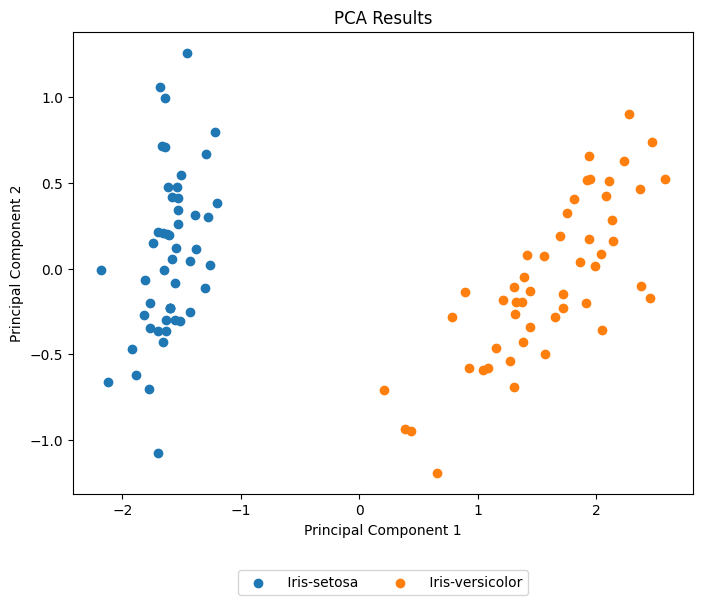

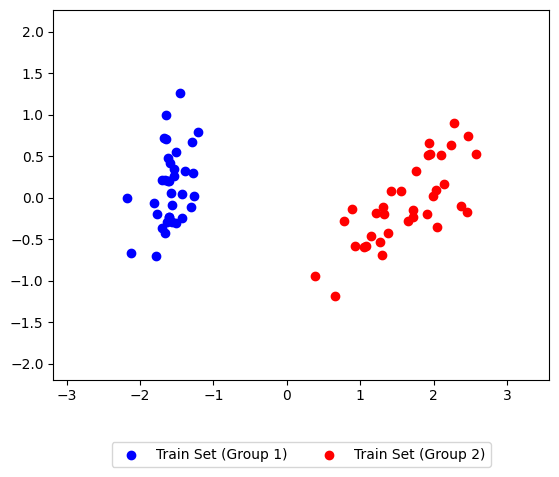

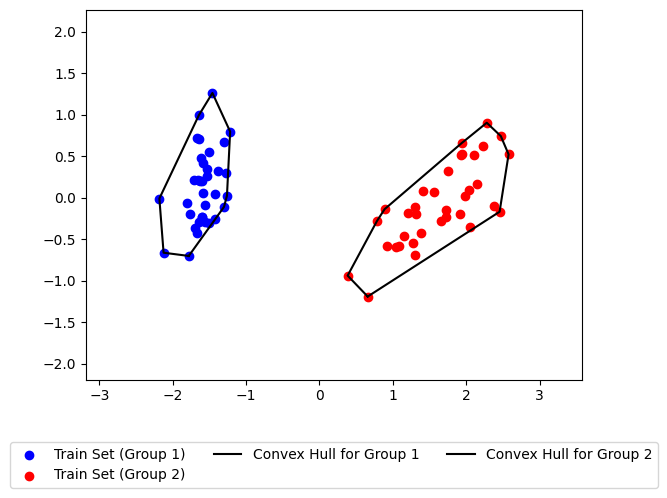

Os grupos não têm interseções nas arestas do convex hull.
Close points
Group1: [-1.3000552472734788, -0.11101032754682183]
Group2: [0.38433693608889546, -0.9390318632322164]


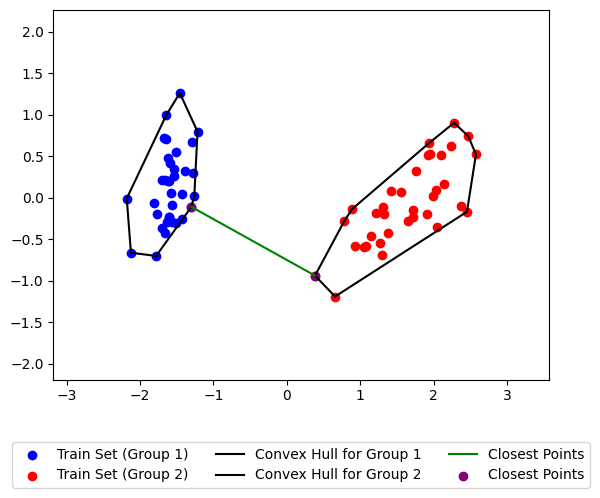

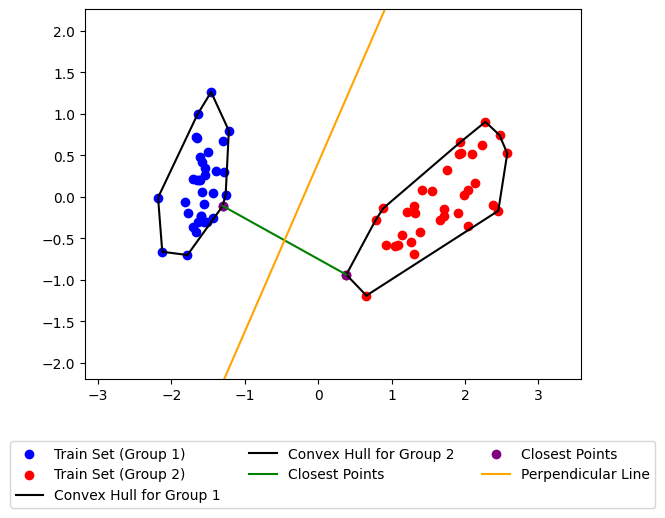

Acertos: 30
Erros: 0
Precisão: 1.0
Recall: 1.0
F1: 1.0


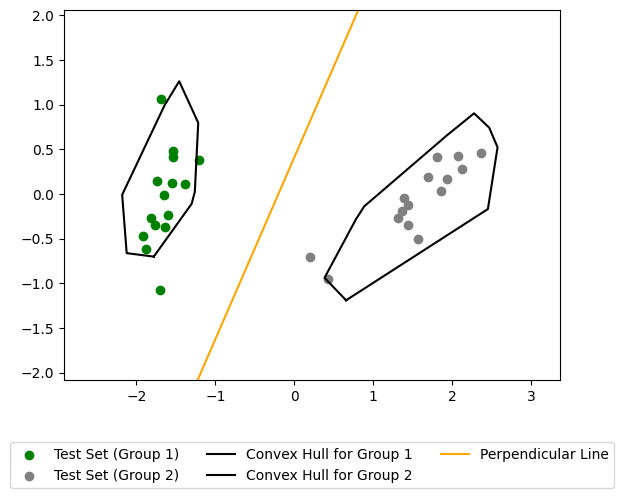

In [23]:
analisa_dataset("iris.dat")

# led7digit

[' 0', ' 1']


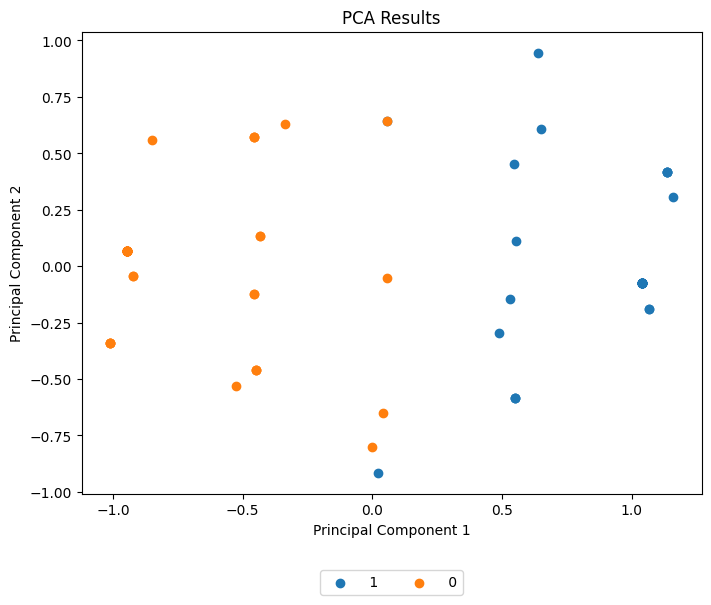

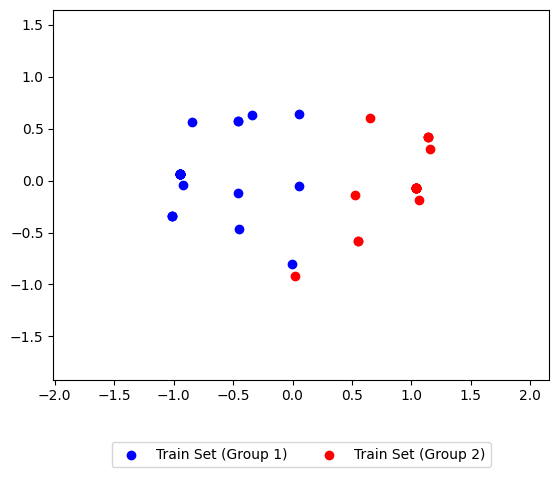

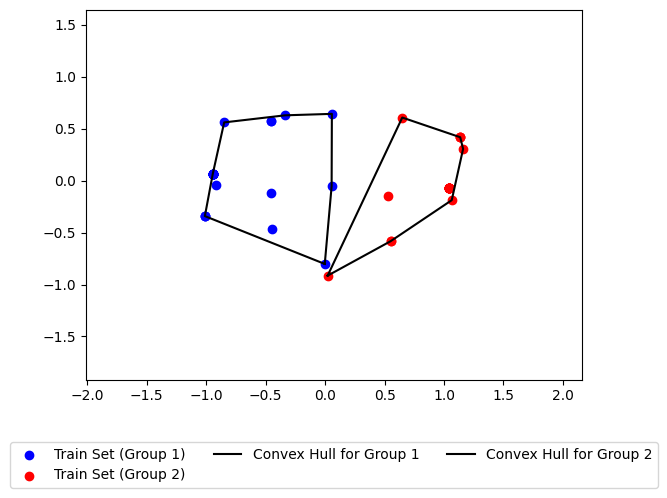

Os grupos não têm interseções nas arestas do convex hull.
Close points
Group1: [-0.0033258596322288383, -0.8020434838923258]
Group2: [0.020843442459189215, -0.9146675079367121]


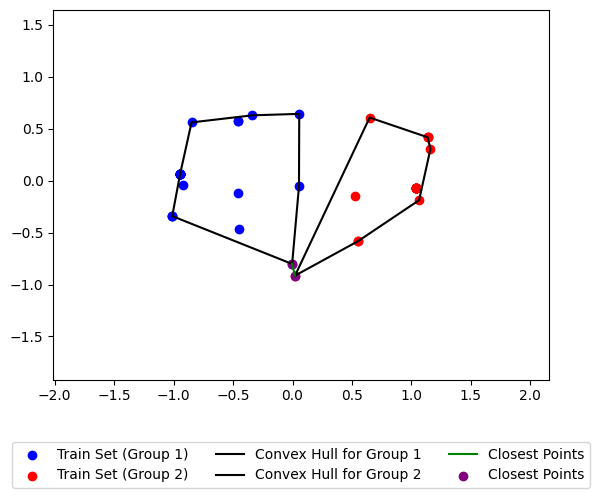

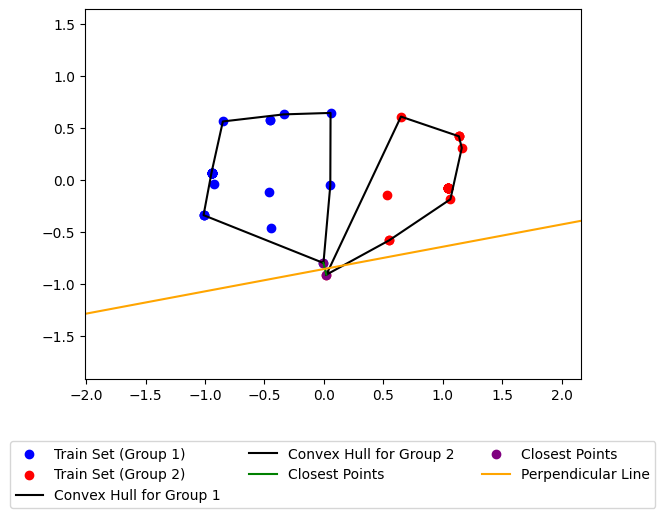

Acertos: 14
Erros: 12
Precisão: 1.0
Recall: 0.5384615384615384
F1: 0.7000000000000001


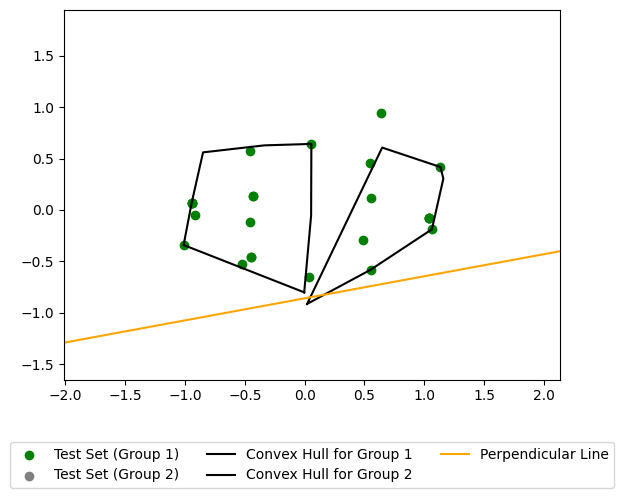

In [24]:
analisa_dataset("led7digit.dat")